In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sklearn
from tqdm import tqdm

import data_interface
import mnar_blackout_lds

In [14]:
import random
random.seed(42)
np.random.seed(42)

In [3]:
# Load the data
x_t, m_t, meta = data_interface.load_panel()

In [7]:
evaluation_windows = data_interface.get_eval_windows("data")

In [27]:
from collections import defaultdict

def stratified_month_sampling(data, n_per_month, ts_key="blackout_start"):
    buckets = defaultdict(list)

    for item in data:
        ts = item[ts_key]
        month_key = (ts.year, ts.month)
        buckets[month_key].append(item)

    result = []
    for month_key, items in buckets.items():
        if len(items) < n_per_month:
            picks = random.choices(items, k=n_per_month)
        else:
            picks = random.sample(items, n_per_month)
        result.extend(picks)

    return result


In [17]:
impute_evaluation_windows = [window for window in evaluation_windows if window["test_type"] == "impute"]
forecast_1_evaluation_windows = [window for window in evaluation_windows if window["test_type"] == "forecast" and window["horizon_steps"] == 1]
forecast_3_evaluation_windows = [window for window in evaluation_windows if window["test_type"] == "forecast" and window["horizon_steps"] == 3]
forecast_6_evaluation_windows = [window for window in evaluation_windows if window["test_type"] == "forecast" and window["horizon_steps"] == 6]

In [28]:
impute_evaluation_windows_val = stratified_month_sampling(impute_evaluation_windows, n_per_month=25, ts_key="blackout_start")
forecast_1_evaluation_windows_val = stratified_month_sampling(forecast_1_evaluation_windows, n_per_month=12, ts_key="blackout_start")
forecast_3_evaluation_windows_val = stratified_month_sampling(forecast_3_evaluation_windows, n_per_month=12, ts_key="blackout_start")
forecast_6_evaluation_windows_val = stratified_month_sampling(forecast_6_evaluation_windows, n_per_month=12, ts_key="blackout_start")

In [20]:
impute_times = [window["blackout_start"] for window in impute_evaluation_windows]
forecast_1_times = [window["blackout_start"] for window in forecast_1_evaluation_windows]
forecast_3_times = [window["blackout_start"] for window in forecast_3_evaluation_windows]
forecast_6_times = [window["blackout_start"] for window in forecast_6_evaluation_windows]

In [29]:
evaluation_windows_val = (forecast_1_evaluation_windows_val +
                              forecast_3_evaluation_windows_val +
                              forecast_6_evaluation_windows_val + impute_evaluation_windows_val)

In [21]:
np.testing.assert_array_equal(np.array(impute_times), np.array(forecast_1_times))
np.testing.assert_array_equal(np.array(impute_times), np.array(forecast_3_times))
np.testing.assert_array_equal(np.array(impute_times), np.array(forecast_6_times))

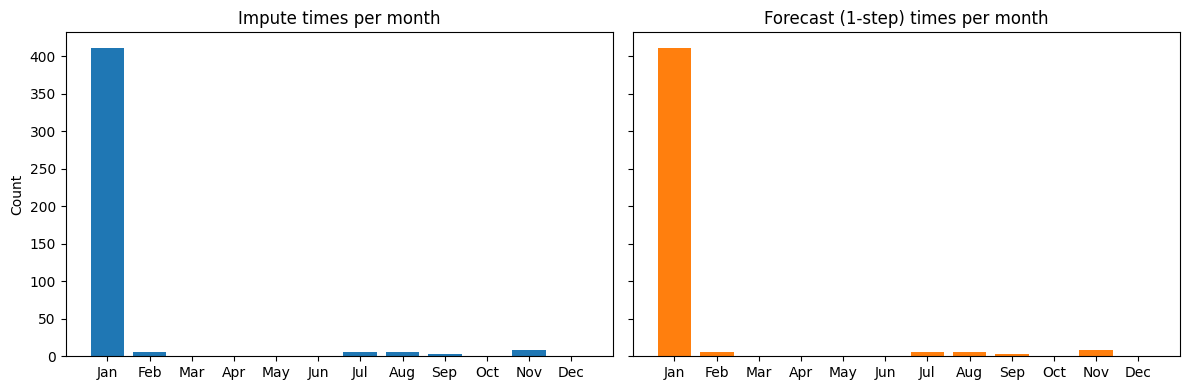

In [22]:
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt

def month_counts(times):
    # convert to datetime and extract month numbers 1-12
    months = pd.to_datetime(times).month
    counts = np.bincount(months, minlength=13)[1:]  # drop index 0
    return counts

impute_counts = month_counts(impute_times)
forecast1_counts = month_counts(forecast_1_times)

month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].bar(month_labels, impute_counts, color='C0')
axes[0].set_title('Impute times per month')
axes[0].set_ylabel('Count')

axes[1].bar(month_labels, forecast1_counts, color='C1')
axes[1].set_title('Forecast (1-step) times per month')

plt.tight_layout()
plt.show()

In [30]:
evaluation_windows_val[0]

{'window_id': 343,
 'detector_id': '405es02553',
 'blackout_start': Timestamp('2015-01-01 00:05:00'),
 'blackout_end': Timestamp('2015-01-01 01:00:00'),
 'len_steps': 12,
 'test_type': 'forecast',
 'horizon_steps': 1.0}

In [31]:
def mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta):
    x_t_masked = x_t.copy()
    m_t_masked = m_t.copy()

    for window in evaluation_windows_val:
        start_idx = np.where(meta["timestamps"]==window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"]==window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"]==window["detector_id"])[0][0]
        
        x_t_masked[start_idx:end_idx+1, detector_idx] = np.nan
        m_t_masked[start_idx:end_idx+1, detector_idx] = 1
    
    return x_t_masked, m_t_masked

In [32]:
# Prepare training data by masking evaluation windows
x_t_train, m_t_train = mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta)

In [4]:
model_params = mnar_blackout_lds.MNARParams.init_random(K=9, D=147, seed=42)
model = mnar_blackout_lds.MNARBlackoutLDS(model_params)

In [ ]:
em_train_history = model.em_train(x_t_train, m_t_train, num_iters=10)


=== EM iteration 1/10 ===
  A norm: 2.963
  Q trace: 4.938
  mean diag(R): 58.312

=== EM iteration 2/10 ===
  A norm: 2.843
  Q trace: 20.078
  mean diag(R): 30.773

=== EM iteration 3/10 ===
  A norm: 2.854
  Q trace: 28.317
  mean diag(R): 28.077

=== EM iteration 4/10 ===
  A norm: 2.860
  Q trace: 33.414
  mean diag(R): 27.765

=== EM iteration 5/10 ===
  A norm: 2.866
  Q trace: 37.171
  mean diag(R): 27.751

=== EM iteration 6/10 ===
  A norm: 2.870
  Q trace: 40.327
  mean diag(R): 27.797

=== EM iteration 7/10 ===
  A norm: 2.872
  Q trace: 43.029
  mean diag(R): 27.832

=== EM iteration 8/10 ===
  A norm: 2.874
  Q trace: 45.008
  mean diag(R): 27.840

=== EM iteration 9/10 ===
  A norm: 2.875
  Q trace: 46.251
  mean diag(R): 27.835

=== EM iteration 10/10 ===
  A norm: 2.877
  Q trace: 46.970
  mean diag(R): 27.822


### Reconstruction and Prediction

In [ ]:
ekf_out = model.ekf_forward(x_t_train, m_t_train)
smoother_out = model.rts_smoother(ekf_out)

mu_filt = ekf_out["mu_filt"]
Sigma_filt = ekf_out["Sigma_filt"]
mu_smooth = smoother_out["mu_smooth"]
Sigma_smooth = smoother_out["Sigma_smooth"]

In [ ]:
# Evaluate imputation performance

impute_mae_list = []
impute_mse_list = []

for window in tqdm(impute_evaluation_windows_val):
    if window["test_type"] == "impute":
        start_idx = np.where(meta["timestamps"]==window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"]==window["blackout_end"])[0][0]

        detector_idx = np.where(meta["detectors"]==window["detector_id"])[0][0]

        eval_x_t = x_t[start_idx:end_idx+1].copy()
        eval_mu_smooth = mu_smooth[start_idx:end_idx+1]
        eval_Sigma_smooth = Sigma_smooth[start_idx:end_idx+1]

        reconstruct_x_t, _ = model.reconstruct_from_smoother(eval_mu_smooth, eval_Sigma_smooth)

        mae = sklearn.metrics.mean_absolute_error(reconstruct_x_t[:, detector_idx], eval_x_t[:, detector_idx])
        mse = sklearn.metrics.mean_squared_error(reconstruct_x_t[:, detector_idx], eval_x_t[:, detector_idx])
        rmse = np.sqrt(mse)
        
        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

final_mae = np.average([item[0] for item in impute_mae_list], weights=[item[1] for item in impute_mae_list])
final_mse = np.average([item[0] for item in impute_mse_list], weights=[item[1] for item in impute_mse_list])
final_rmse = np.sqrt(final_mse)

print("Final MAE (impute):", final_mae)
print("Final MSE (impute):", final_mse)
print("Final RMSE (impute):", final_rmse)

100%|██████████| 1764/1764 [00:00<00:00, 4692.34it/s]

Final MAE (impute): 1.6935249175996532
Final MSE (impute): 5.645882503504708
Final RMSE (impute): 2.376106585047209


In [ ]:
# Evaluate forecasting performance

y_actual_1_step, y_forecast_1_step = [], []
y_actual_3_step, y_forecast_3_step = [], []
y_actual_6_step, y_forecast_6_step = [], []

forecast_evaluation_windows_val = (forecast_1_evaluation_windows_val +
                                   forecast_3_evaluation_windows_val +
                                   forecast_6_evaluation_windows_val)

for window in tqdm(forecast_evaluation_windows_val):
    if window["test_type"] == "forecast":
        start_idx = np.where(meta["timestamps"]==window["blackout_start"])[0][0]
        blackout_idx = start_idx - 1

        end_idx = np.where(meta["timestamps"]==window["blackout_end"])[0][0]

        detector_idx = np.where(meta["detectors"]==window["detector_id"])[0][0]

        eval_x_t = x_t[start_idx:end_idx+1].copy()

        forecast_x_t, _ = model.k_step_forecast(mu_filt, Sigma_filt, blackout_idx, k=int(window["horizon_steps"]))
        
        if int(window["horizon_steps"]) == 1:
            y_forecast_1_step.append(forecast_x_t[detector_idx])
            y_actual_1_step.append(eval_x_t[int(window["horizon_steps"])-1, detector_idx])
        elif int(window["horizon_steps"]) == 3:
            y_forecast_3_step.append(forecast_x_t[detector_idx])
            y_actual_3_step.append(eval_x_t[int(window["horizon_steps"])-1, detector_idx])
        elif int(window["horizon_steps"]) == 6:
            y_forecast_6_step.append(forecast_x_t[detector_idx])
            y_actual_6_step.append(eval_x_t[int(window["horizon_steps"])-1, detector_idx])

mae_1_step = sklearn.metrics.mean_absolute_error(y_forecast_1_step, y_actual_1_step)
mse_1_step = sklearn.metrics.mean_squared_error(y_forecast_1_step, y_actual_1_step)
rmse_1_step = np.sqrt(mse_1_step)

print("Evaluation results for forecasting:")
print("\n-----------------------------------")
print("1-step MAE (forecast):", mae_1_step)
print("1-step MSE (forecast):", mse_1_step)
print("1-step RMSE (forecast):", rmse_1_step)


mae_3_step = sklearn.metrics.mean_absolute_error(y_forecast_3_step, y_actual_3_step)
mse_3_step = sklearn.metrics.mean_squared_error(y_forecast_3_step, y_actual_3_step)
rmse_3_step = np.sqrt(mse_3_step)
print("\n-----------------------------------")
print("3-step MAE (forecast):", mae_3_step)
print("3-step MSE (forecast):", mse_3_step)
print("3-step RMSE (forecast):", rmse_3_step)

mae_6_step = sklearn.metrics.mean_absolute_error(y_forecast_6_step, y_actual_6_step)
mse_6_step = sklearn.metrics.mean_squared_error(y_forecast_6_step, y_actual_6_step)
rmse_6_step = np.sqrt(mse_6_step)
print("\n-----------------------------------")
print("6-step MAE (forecast):", mae_6_step)
print("6-step MSE (forecast):", mse_6_step)
print("6-step RMSE (forecast):", rmse_6_step)

100%|██████████| 1764/1764 [00:00<00:00, 10201.31it/s]

Evaluation results for forecasting:

-----------------------------------
1-step MAE (forecast): 2.1523494370570853
1-step MSE (forecast): 8.918860825804575
1-step RMSE (forecast): 2.986446186658078

-----------------------------------
3-step MAE (forecast): 1.6765516351880905
3-step MSE (forecast): 4.761804266464367
3-step RMSE (forecast): 2.1821558758403046

-----------------------------------
6-step MAE (forecast): 1.490643806003054
6-step MSE (forecast): 4.163694755538252
6-step RMSE (forecast): 2.0405133558833306


In [10]:
len(impute_mae_list), len(y_actual_1_step), len(y_actual_3_step), len(y_actual_6_step)

(441, 441, 441, 441)